# Exercise: Create your own database using a compressed binary file

## Generate Fake Data File

In [ ]:
!pip install Faker

In [ ]:
from faker import Faker
import random
import pandas as pd
import os

#create 1000.0000 users file

user_columns = ['id','name','email','phone','company','street','street_number', 'zipcode','country','birthdate']

#User storage: name:
#id, street_number: 8 bytes (2 x 32 bitnumbers between 0 and 2^31)
#name','email','phone','company','street','zipcode','country: strings of n characters requires n bytes: e.g. +-100 bytes
def generate_data(size):
  users = []
  fake = Faker()
  for i in range(0,size):
    user = [i, fake.name(), fake.ascii_email(), fake.basic_phone_number(), fake.company(), fake.street_name(), random.randint(1,1000), fake.zipcode(), fake.country(), f'{random.randint(1970,2005)}-{random.randint(1,12)}-{random.randint(1,28)}']
    users.append(user)
  df = pd.DataFrame(users,columns=user_columns)
  return df

size = 10000
df = generate_data(size) #Takes about 1 minutes to run or about 12 minutes for 1000000 rows
display(df)

## Save and load CSV file

In [ ]:
import time

start = time.time()
fname = 'fake_users.csv'
df.to_csv(fname, index=False)
file_size = os.stat(fname).st_size
print(f"CSV file size is {file_size}B. Elapsed: {time.time()-start}s")
#File Size in Bytes is 1182617 (or on average 120 bytes per record) in csv.


In [ ]:
start = time.time()
df = pd.read_csv('fake_users.csv')
print(f"Loading CSV. Elapsed: {time.time()-start}s")
display(df)
display(df.describe(include='all'))

In [ ]:
#get some stats required for encoding, such as length of faker strings
for col in df.columns:
  print(col)
  if pd.api.types.is_int64_dtype(df[col].iloc[0]):
    print(f'col {col} is integer. range: {df[col].min()}-{df[col].max()}. unique: {df[col].nunique()}')
  elif isinstance(df[col].iloc[0],str):
    print(f'col {col} is string. range: {df[col].apply(len).min()}-{df[col].apply(len).max()}. unique: {df[col].nunique()}')

# Fixed-length binary file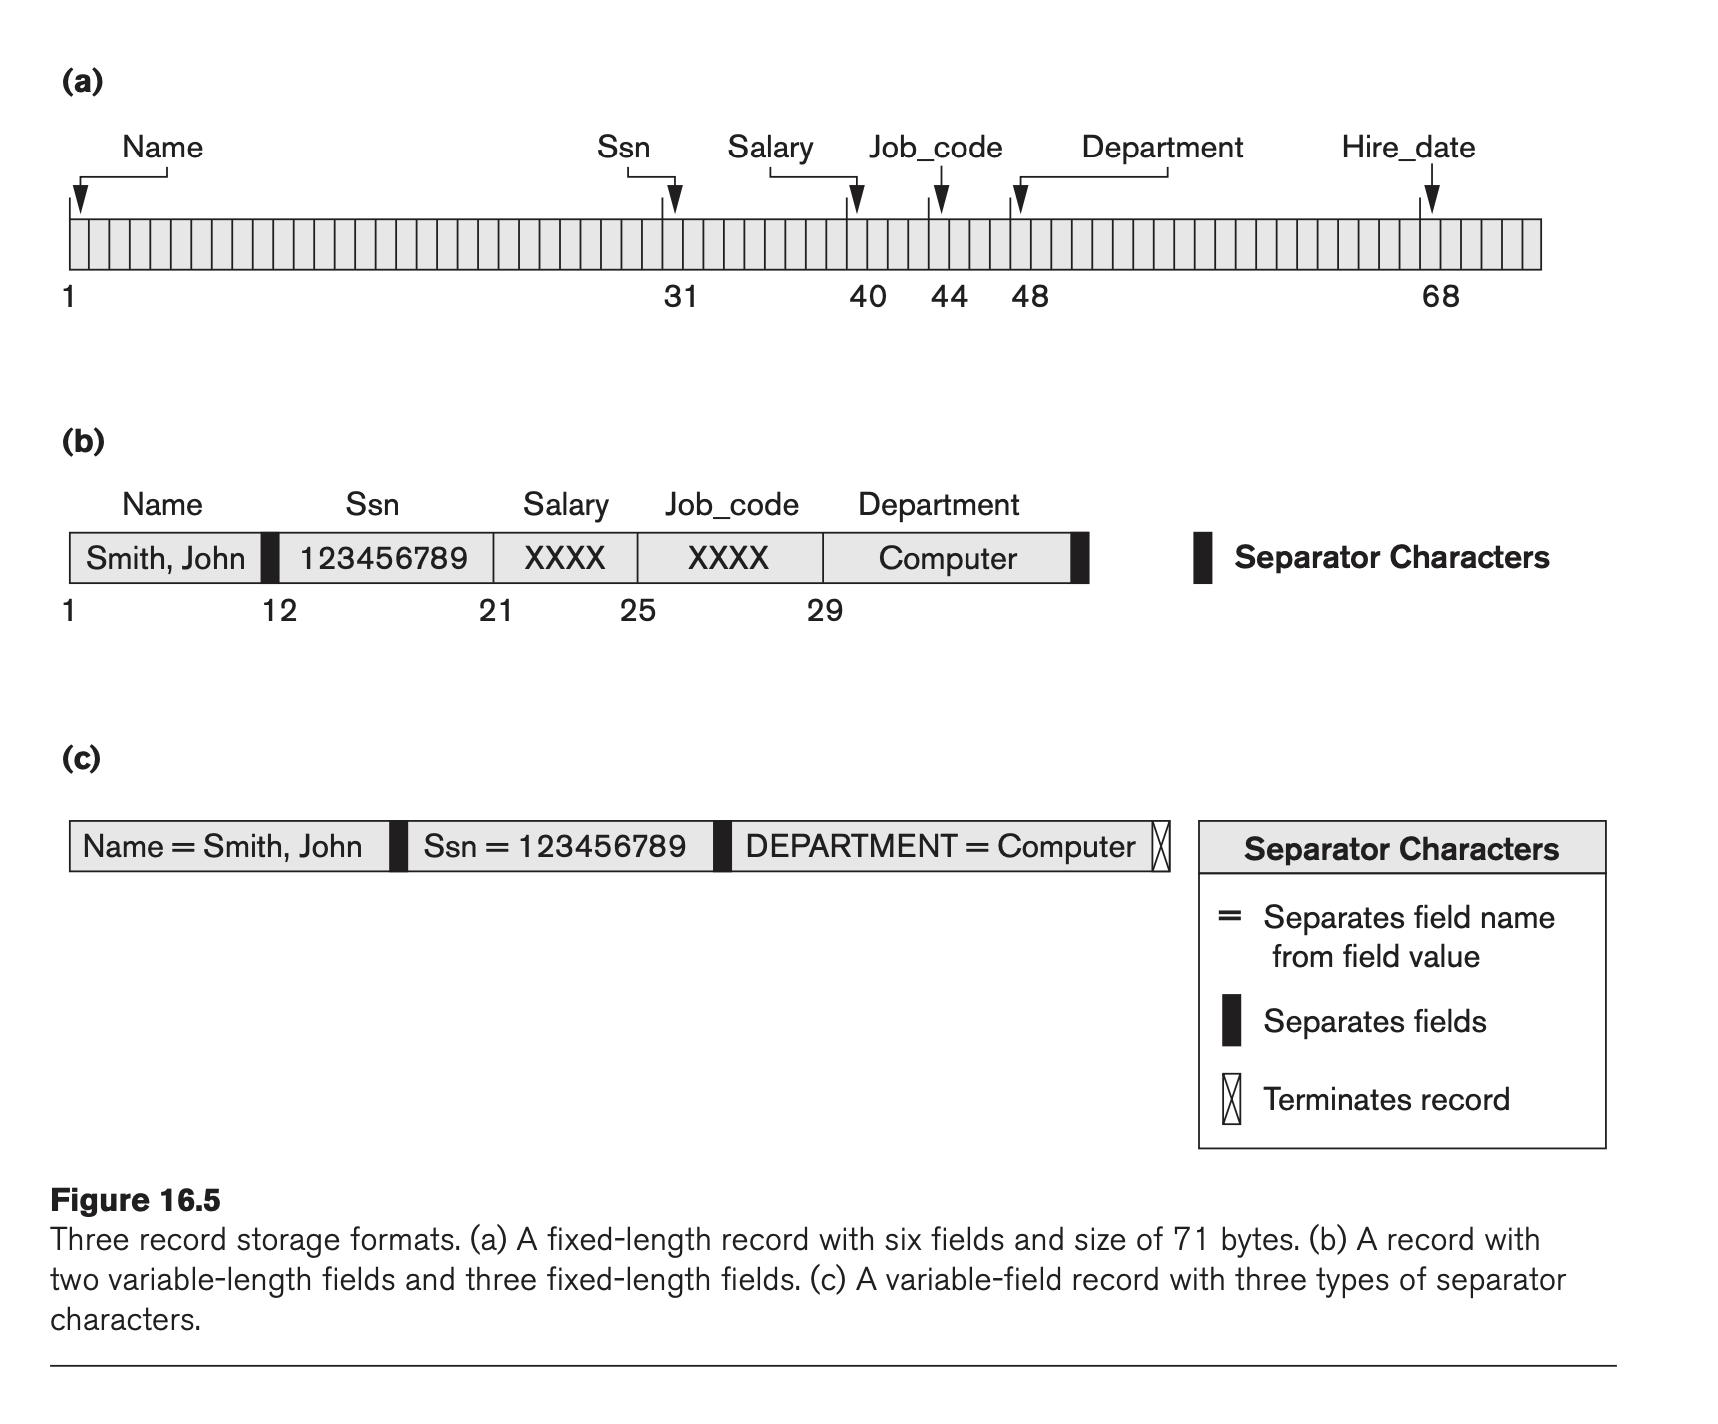

## Encode and decode tuple to fixed-lengh binary string

In [ ]:
#convert tuple to binary
import struct #See https://docs.python.org/3/library/struct.html

"""
Using struct python package to convert to binary vector
">" : litle endian (general format that defined order)
"H" " unsigned short integer (2 bytes )
"I" :  unsigned integer (4 bytes)
"32s" = string of max length 32 (32 bytes). If string is smaller, padding with 0 (less efficient)
columns: ['id','name','email','phone','company','street','street_number', 'zipcode','country','birthdate']
            I    32s    64s      16s     64s      32s          H             I          64s      16s
"""
format = '>I32s64s16s64s32sHI64s16s'
size_user = struct.calcsize(format)
print(f'size of user: {size_user}B')

def encode_user(user_row):
  """
  Convert user tuple to fixed-length binary vector
  :param user_row: user tuple/array where colums are ['id','name','email','phone',...]
  :return: binary representation of user tuple
  """
  values = [ value.encode('ascii') if isinstance(value,str) else value for value in user_row]
  return struct.pack(format, *values)

def decode_user(binary_string):
  """
  Convert from  fixed-length binary vector to user_tuple
  :param binary_string: user as binary string
  :return: user tuple with ['id','name','email','phone',...]
  """
  values = struct.unpack(format, binary_string)
  values = [ value.decode('ascii').replace('\x00','') if not isinstance(value,int) else value for value in values]
  return values

#test:
first_row = df.iloc[0]
binary_row = encode_user(first_row)
print(f'first user: {first_row.values}')
print(binary_row)
print(f'encode: {len(binary_row)}')
#Remark that binary size is very large, due to padding to fixed length
#One solution (not implemented) is to work with varying length tuples,
#todo i.e. storing the length first and the characterd "3abc" instead of fixed-length padding like "00000000000abc"
first_row = decode_user(binary_row)
print(f'decode_user: {first_row}')


## Exercise 1: Save and load to binary file

**Exercise 1: Complete code to save and load from binary file**

Use *file* from python, see https://docs.python.org/3/tutorial/inputoutput.html

*file* API:

- *fh = open(filename, mode)*, e.g. mode can be "rb" (read binary), "rw" (write new binary file) or "r+b" (read and write existing binary file)
- *fh.read(N)* returns byte array with *N* bytes or False if nothing to read
- *fh.write(bytearray)* write (or appends) bytearray at current position
- *fh.seek(N)* go to file position starting at *N* bytes

In [ ]:
def save_users_to_binary_file(filename, df):
  """
  Saves users to sorted fixed-length binary file
  :param filename: binary file to save
  :param df: pandas dataframe contains all users
  :return:
  """
  start = time.time()
  # Create new file or existing
  with open(filename, "wb") as fh:
      for user in df.itertuples(index=False):
        fh.write(encode_user(user))
  print(f'saved {df.shape[0]} records to {filename}. Time: {time.time() -start}s')

def load_user_from_binary_file(filename,user_columns=user_columns):
  """
  Loads users from sorted fixed-length binary file
  :param filename: binary file to load
  :user_columns: name of columns
  :return: pandas dataframe with all user tuples
  """
  start = time.time()
  users = []
  fh = open(filename, "rb")
  i = 0
  while True:
    binary_user = fh.read(size_user)
    if not binary_user or len(binary_user) < size_user:
      print(f'end of file reached {binary_user}')
      break
    user = decode_user(binary_user)
    users.append(user)
    i += 1
  print(f'loaded {i} records from {filename}. Time: {time.time() -start}s')
  return pd.DataFrame(users,columns=user_columns)

In [ ]:
#save
fname_bin = 'fake_users.bin'
save_users_to_binary_file(fname_bin, df)
file_size = os.stat(fname_bin).st_size
print(f"File size is {file_size}B")

In [ ]:
#load
df2 = load_user_from_binary_file(fname_bin)
display(df2)

## Excercise 2: Random access

**Exercise 2: Complete code to save and load single a record using random access (i.e. file.seek)**



In [ ]:
def read_user(user_id, fh):
  """
  Random access to read fixed-length user tuple in sorted file
  :param user_id: id of user data to read
  :param fh: file handle
  :return: decoded user tuple
  """
  fh.seek(user_id*size_user)
  return decode_user(fh.read(size_user))


def write_user(user, fh):
  """
  Random acces to write/update fixed-length user tuple in sorted file
  :param user: user tuple/array where colums are ['id','name','email','phone',...]
  :param fh: file handle
  :return: updated user tuple in file
  """
  fh.seek(user[0]*size_user)
  fh.write(encode_user(user))

  

In [ ]:
#Read 4 random users
with open(fname_bin,"rb") as fh:
  random_ids = [0, 100, 200, 9999]
  random_users = []
  for id in random_ids:
    user_i = read_user(id, fh)
    random_users.append(user_i)
  print(f'Loading {len(random_ids)} random users. Elapsed: {time.time() -start}s')
df_sample = pd.DataFrame(random_users,columns=user_columns)
display(df_sample)

In [ ]:
#Update 4 random users
fh = open(fname_bin,"r+b") #open file for updating with "r+b", do not use "wb" since otherwise file will be blank!
start = time.time()
random_ids = [0, 100, 200, 9999]
for user in random_users:
  user[1] = 'X ' + user [1]
  write_user(user,fh)
print(f'Writing {len(random_ids)} random users. Elapsed: {time.time() -start}s')
fh.close()

# Compressed varying-length binary file


## Compress country using dictionary encoding
If domain has low cardinality, we encode each option using a dictionary, e.g. {'M','F'} can be stored as {0,1}, or {'Afghanistan', 'Albania' ... } can be encoded as {0,...242} if we have 243 distinct country names

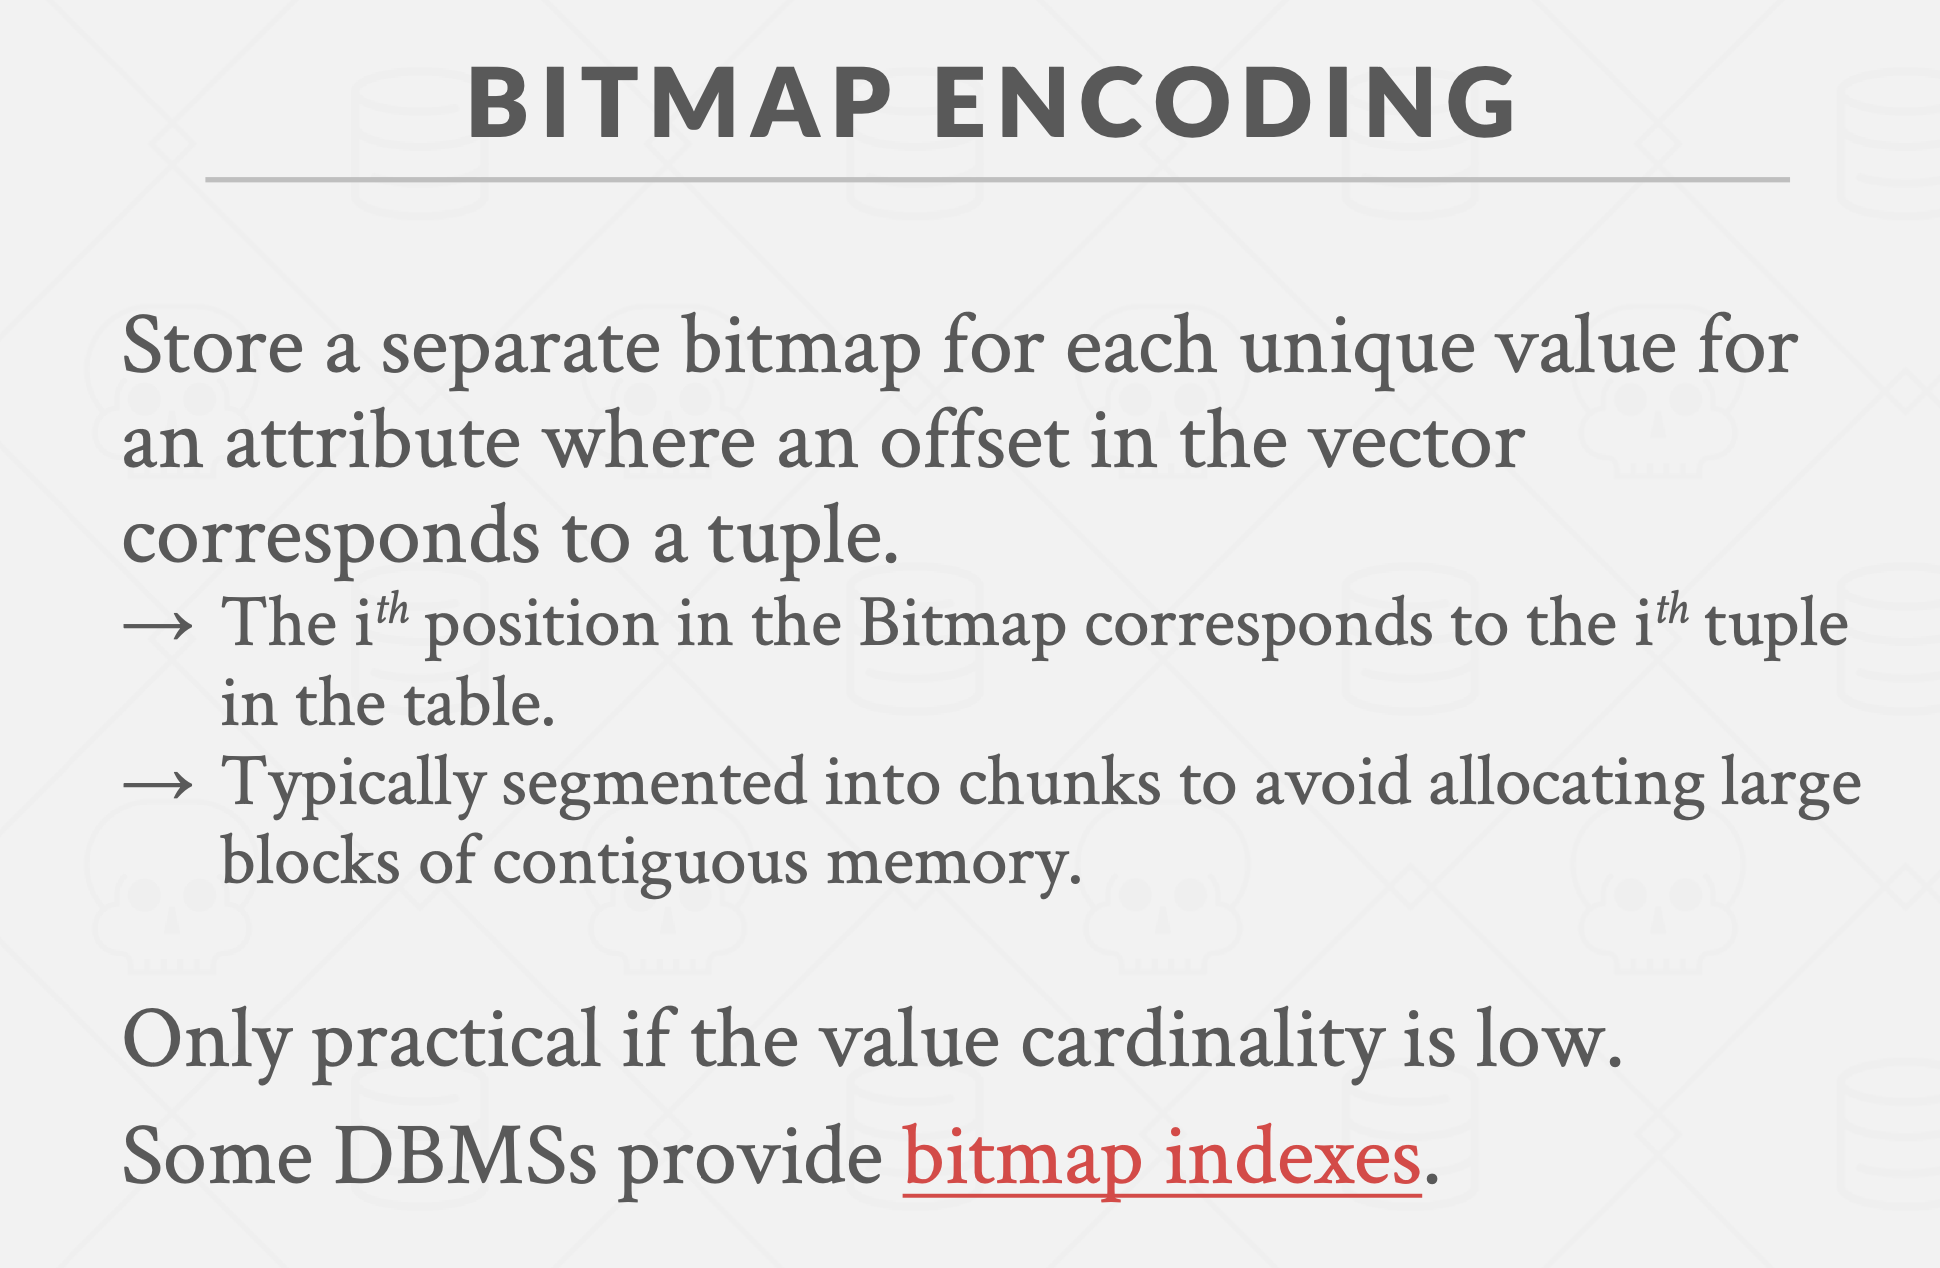

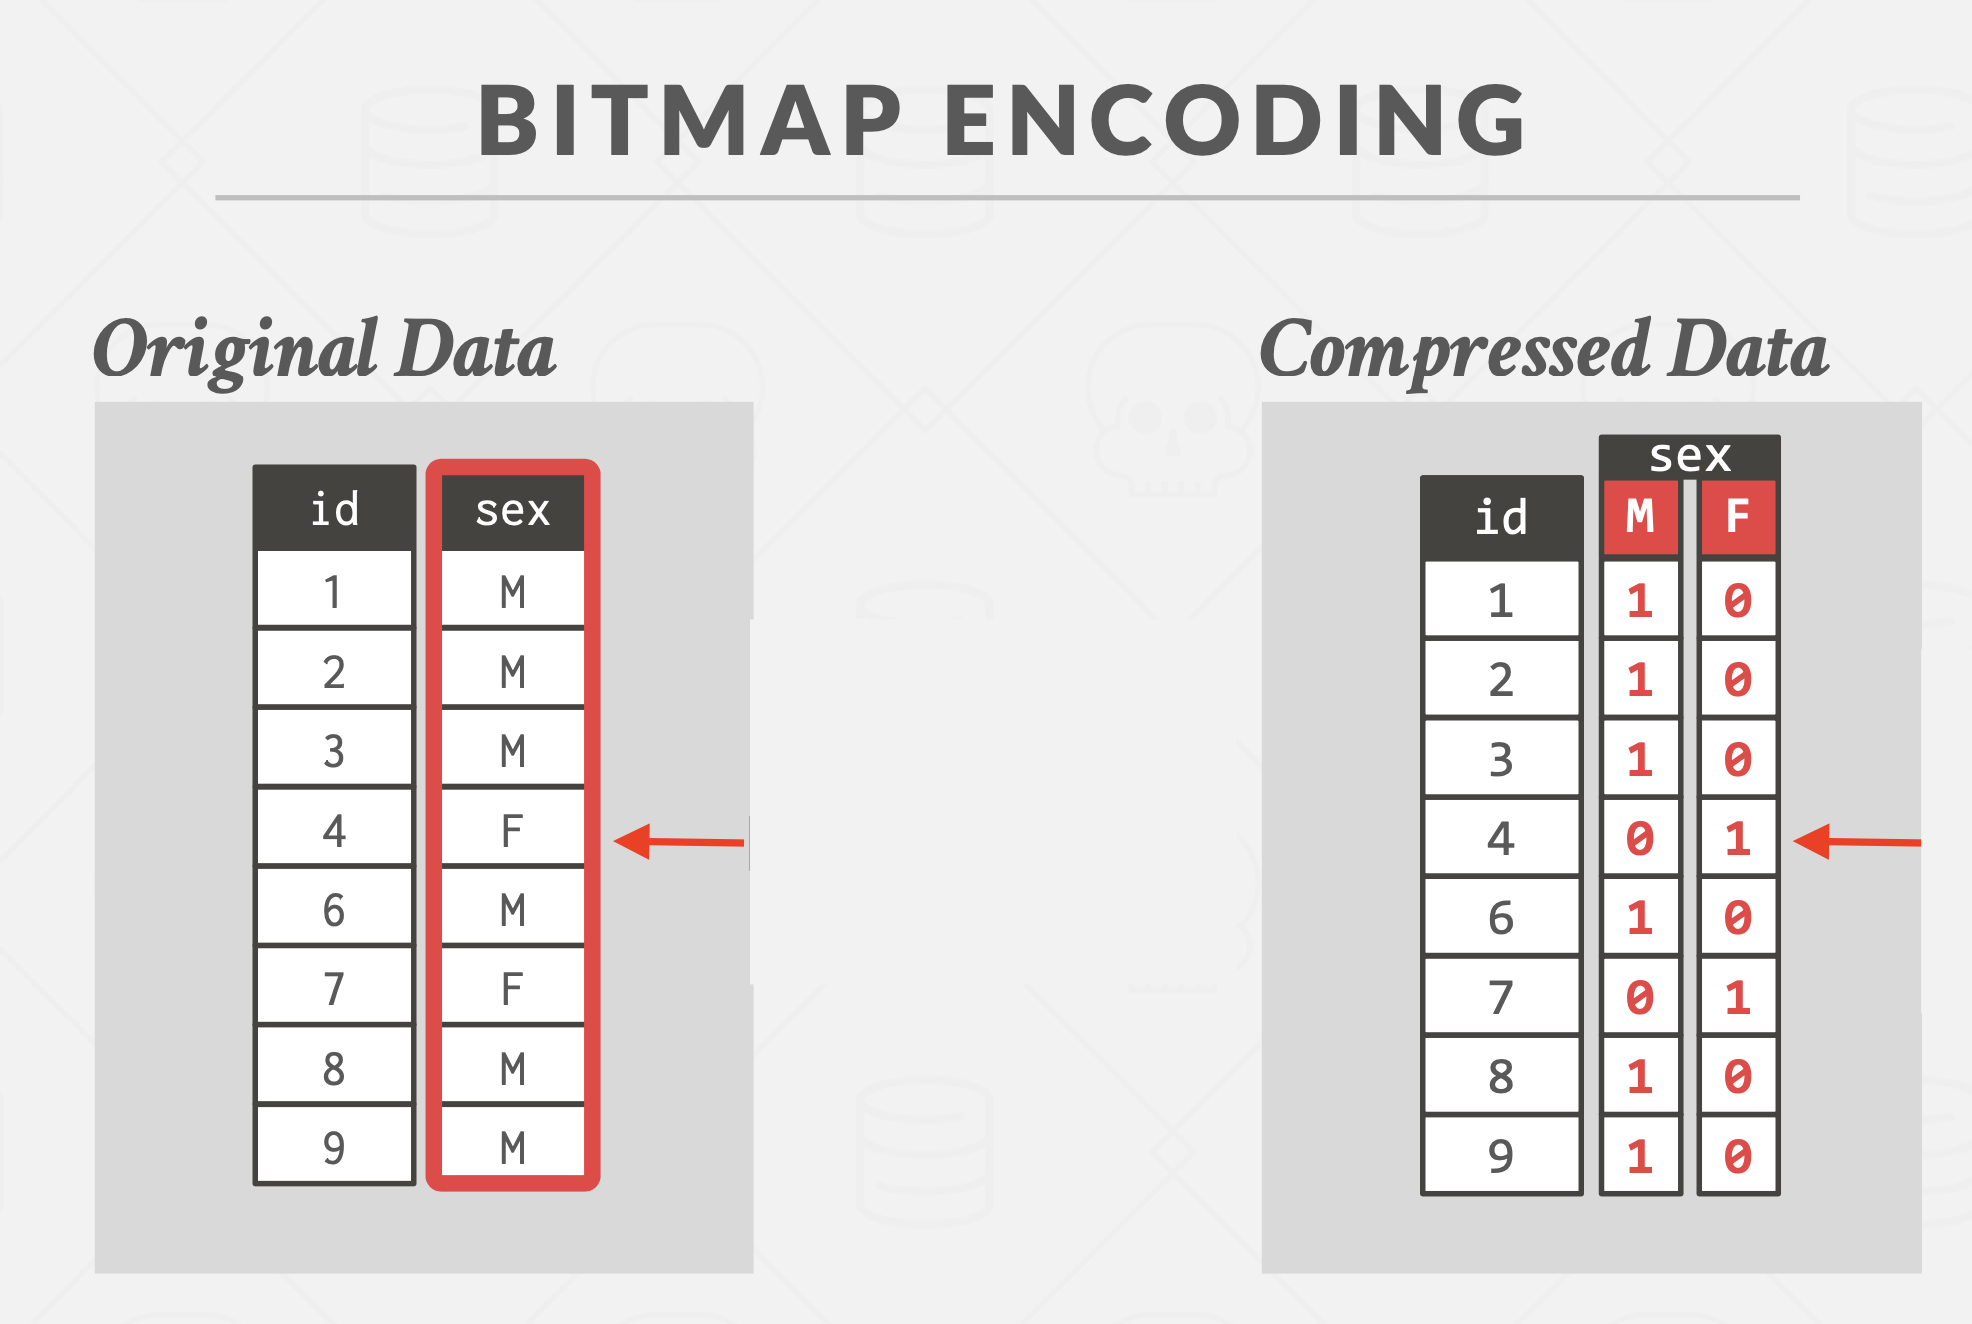

## Excercise 3: Modify dataframe and encode country using bitmap encoding
**Exercise 3: Encode country using bitmap encoding. You can assume the dictionary itself does not need to be stored**

*Pandas* API:
- *df[col]*: returns a single column with name *col* as series
- *df[col].values*: returns a single column as *numpy* array
- *list(df[col].values)*: returns a single column as *python* list
- *df[col].unique()*: returns all unique (or distinct) values
- *df[col].apply(f)*: applies (or runs) the function f to all column values
- *df[col2] = df[col].apply(f)*: applies (or runs) the function f to all column values and store the result in a new column


In [ ]:
def encode_dictionary(df, col):
  """
  Creates column df[col + '_dct'] containing dictionary value
  :param df: pandas dataframe
  :param col: column to apply dictionary encoding
  :return mapping between value and code
  """
  unique_values = sorted(df[col].unique())
  value_to_code = {value: i for i, value in enumerate(unique_values)}
  df[f'{col}_dct'] = df[col].apply(lambda x: value_to_code[x])
  return value_to_code

In [ ]:
"""
Before: col country is string. range: 4-51. unique: 243
After: country "id" encoded using dictionary and store as 16 bit integer
"""
value_to_code_countries = encode_dictionary(df,'country')
print(value_to_code_countries)

## Timestamp encoding of birthdate
Birthdate encoded as string, i.e. "1986-11-20" takes 10 bytes. Encodes
as timestamp, i.e. number of seconds since January 1st, 1970, takes 4 bytes.

In [ ]:
import datetime
"""
col birthdate is string. range: 8-10. unique: 7971
  -> Convert to timestamp  with 32bits
"""
df['birthdate_ts'] = df['birthdate'].apply(lambda s:  pd.to_datetime(s,format='%Y-%m-%d'))
df['birthdate_ts'] = df['birthdate_ts'].astype(int) / 10**9


In [ ]:
df = df[['id',	'name', 'email',	'phone', 'company', 'street', 'street_number', 'zipcode', 'country_dct', 'birthdate_ts']]
display(df)
new_user_columns = list(df.columns.values)
print(new_user_columns)

# Varying-length binary file

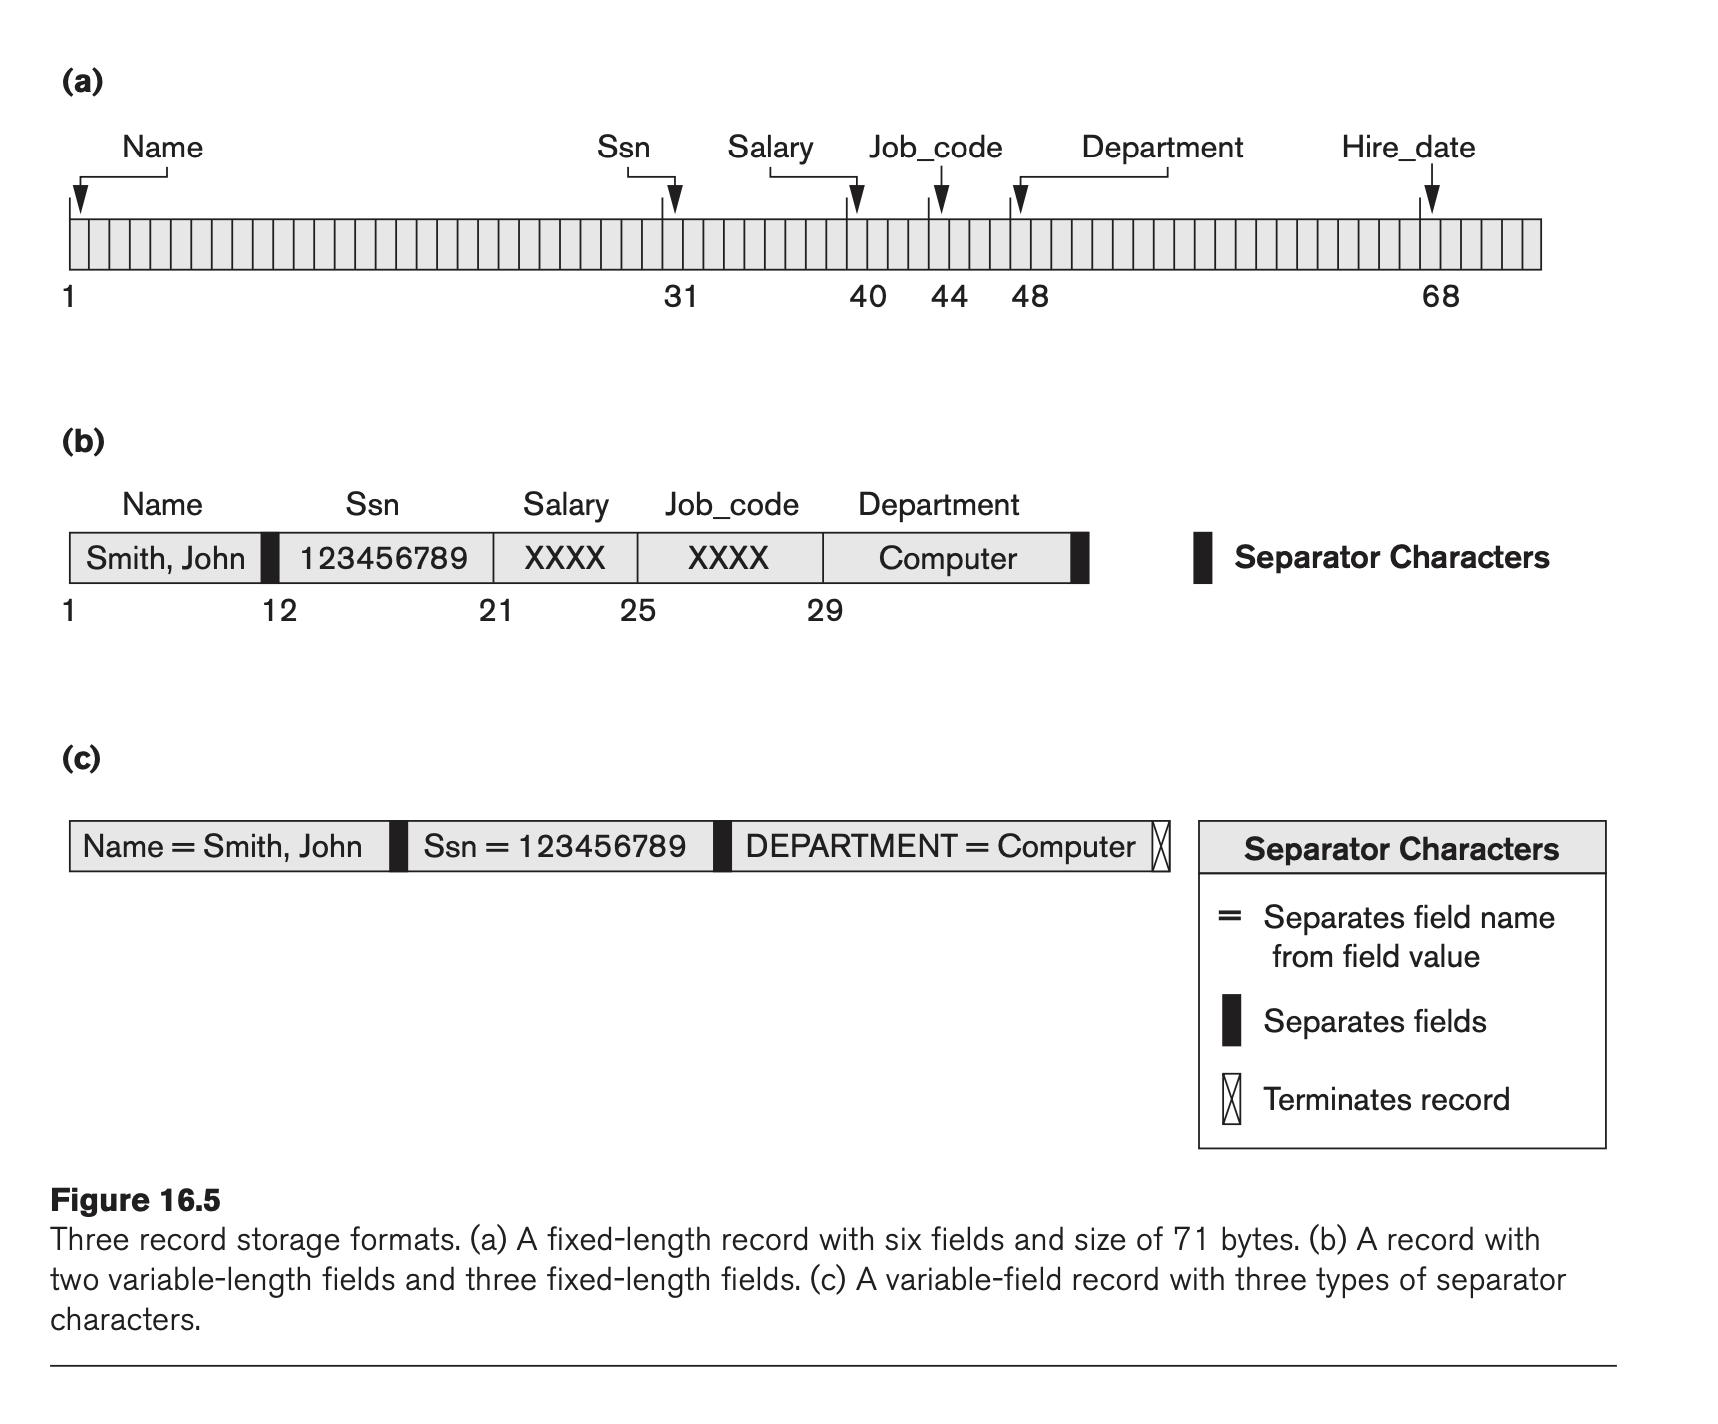

## Encode variable-length tuples


In [ ]:
#some constants for efficiency
IDX_ID = new_user_columns.index('id')
IDX_SN = new_user_columns.index('street_number')
IDX_ZIP = new_user_columns.index('zipcode')
IDX_BD = new_user_columns.index('birthdate_ts')
IDX_COUNTRY = new_user_columns.index('country_dct')
IDX_NAME = new_user_columns.index('name')
IDX_EMAIL = new_user_columns.index('email')
IDX_PHONE = new_user_columns.index('phone')
IDX_COMPANY = new_user_columns.index('company')
IDX_STREET = new_user_columns.index('street')

def encode_var_string(s):
  return [len(s)] + list(s.encode('ascii'))

def encode_user_var_length(user):
  '''
  Assuming user has columns
  ['id', 'name', 'email', 'phone', 'company', 'street', 'street_number', 'zipcode', 'country_dct', 'birthdate_ts']

  encode user object:
  id, street_number, zipcode, birthdate_ts, country_dct
    -> to integer between 1 and 4 bytes depending on range values
  name, email, phone, company, street
    -> to variable-length string, e.g. "helloworld" -> (8,"helloworld") instead of using padding, e.g."0000000helloworld"
  '''
  int_list = []
  int_list.extend(int(user[IDX_ID]).to_bytes(4,'little'))
  int_list.extend(int(user[IDX_SN]).to_bytes(2,'little')) #max street number < 65536 (or 2^16)
  int_list.extend(int(user[IDX_ZIP]).to_bytes(4,'little'))
  int_list.extend(int(user[IDX_BD]).to_bytes(4,'little'))
  int_list.extend(int(user[IDX_COUNTRY]).to_bytes(1,'little')) #max country < 256 (or 2^8)
  int_list.extend(encode_var_string(user[IDX_NAME]))
  int_list.extend(encode_var_string(user[IDX_EMAIL]))
  int_list.extend(encode_var_string(user[IDX_PHONE]))
  int_list.extend(encode_var_string(user[IDX_COMPANY]))
  int_list.extend(encode_var_string(user[IDX_STREET]))
  return bytearray(int_list)

## Excercise 4: Write code to decode byte_array

**Exercise 4: Complete the following code to decode a single user tuple encoded as bytes using encode_user_var_length**
API:
- *byte_array[start:end]* : get sub-array of bytes
- *int.from_bytes(byte_array_slice, "little")*: get python integer from byte array. Note that small integer can be 1 byte, and large integer can be 4 bytes or more.
- *str(byte_array_slice, encoding='ascii')*: get python string encoded as ascii


In [ ]:
def decode_user_var_length(byte_array):
   '''
   decode variable-length tuple representing user (see encode_user_var_length)
   '''
   get_int = lambda x: int.from_bytes(x, 'little')
   get_string = lambda x: str(x, encoding='ascii')
   
   id = get_int(byte_array[:4])
   street_number = get_int(byte_array[4:6])
   zipcode = get_int(byte_array[6:10])
   bd = get_int(byte_array[10:14])
   country_dct = get_int(byte_array[14:15])


   # Precompute repeated index calculations
   idx_name_start = 16
   idx_name_len = byte_array[15]
   idx_name_end = idx_name_start + idx_name_len

   name = get_string(byte_array[idx_name_start:idx_name_end])
   
   idx_email_start = idx_name_end + 1
   idx_email_len = byte_array[idx_name_end]
   idx_email_end = idx_email_start + idx_email_len
   
   email = get_string(byte_array[idx_email_start:idx_email_end])
   
   idx_phone_start = idx_email_end + 1
   idx_phone_len = byte_array[idx_email_end]
   idx_phone_end = idx_phone_start + idx_phone_len
   
   phone = get_string(byte_array[idx_phone_start:idx_phone_end])

   idx_company_start = idx_phone_end + 1
   idx_company_len = byte_array[idx_phone_end]
   idx_company_end = idx_company_start + idx_company_len

   company = get_string(byte_array[idx_company_start:idx_company_end])

   idx_street_start = idx_company_end + 1
   idx_street_len = byte_array[idx_company_end]
   idx_street_end = idx_street_start + idx_street_len

   street = get_string(byte_array[idx_street_start:idx_street_end])
   
   print("Debug: id", id)  # Debug print
   print("Debug: street_number", street_number)  # Debug print

   return (id, name, email, phone, company, street, street_number, zipcode, country_dct, bd)

In [ ]:
#test
first_user = df.iloc[0]
print(first_user.values)
byte_array = encode_user_var_length(first_user)
print(f'byte array len: {len(byte_array)}: {byte_array}') #107 bytes instead of 298 bytes!
user = decode_user_var_length(byte_array)
print(f'decoded: {user}')
if first_user.values.any() != user:
    print('Error: first_user != user')

## Save and load to file varying-length to binary file
Use slotted pages. Start of file contains array of N integer (32 bits) with location of tuples. Then we store varying-lengh binary encoding of tuples sequentially.

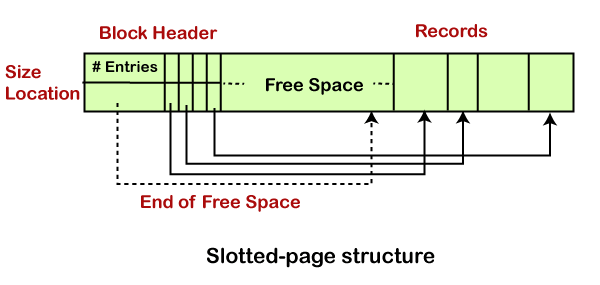

## Excercise 5: Save varying-length user tuples
Write code to save header containing offsets to tuples and tuples in binary file. Also write code to read binary file.

The file layout could be: $[N, \mathit{offset}_1, \mathit{offset}_2, \ldots, \mathit{offset}_N, \mathit{offset}_{N+1}, t_1, t_2, \ldots, t_N]$



In [ ]:
def save_users_to_binary_var_length(filename, df):
  """
  saves users to sorted variable-length binary file
  file layout: [N offset_t1 offset_t2... offset_tN offset_tN+1 t1 t2 ... tN]

  :param filename: binary file to save
  :param df: pandas dataframe contains all users
  :return:
  """
  start = time.time()
  number_of_slots = df.shape[0]
  
  with open(filename, "wb") as file:
      file.write(number_of_slots.to_bytes(4, 'little'))

      start_offset = 4 * (number_of_slots + 2)
      offsets = [start_offset]
      
      file.seek(start_offset)
      for user in df.itertuples(index=False):
          encoded_user = encode_user_var_length(user)
          # print(encoded_user)
          file.write(encoded_user)
          start_offset += len(encoded_user)
          offsets.append(start_offset)

    
      file.seek(4)
      for offset in offsets:
          file.write(offset.to_bytes(4, 'little'))

  print(f'saved {number_of_slots} records to {filename}. Time: {time.time() - start}s')

def load_users_from_binary_var_length(filename):
  """
  load users from sorted variable-length binary file
  file layout: [N offset_t1 offset_t2... offset_tN offset_tN+1 t1 t2 ... tN]

  :param filename: binary file to save
  :return: pandas dataframe contains all users
  """
  start = time.time()
  #read slots
  with open(filename, "rb") as file:
    number_of_slots = int.from_bytes(file.read(4), "little")
    offsets = [int.from_bytes(file.read(4), "little") for _ in range(number_of_slots + 1)]
    

    users = []
    for i in range(number_of_slots):    
        file.seek(offsets[i])
        user = file.read(offsets[i + 1] - offsets[i])

        user = decode_user_var_length(user)
        users.append(user)

    print(f'loaded {number_of_slots} records from {filename}. Time: {time.time() - start}s')
    return pd.DataFrame(users, columns=new_user_columns)
  
  #save
fname_bin = 'fake_users.bin2'
save_users_to_binary_var_length(fname_bin, df)
file_size = os.stat(fname_bin).st_size
print(f"File size is {file_size}B") #was 2980000B, know 999927B (about 33% of fixed-length)
  #load
df2 = load_users_from_binary_var_length(fname_bin)
display(df2)


#save
fname_bin = 'fake_users.bin2'
save_users_to_binary_var_length(fname_bin, df)
file_size = os.stat(fname_bin).st_size
print(f"File size is {file_size}B") #was 2980000B, know 999927B (about 33% of fixed-length)

In [ ]:
#load
df2 = load_users_from_binary_var_length(fname_bin)
display(df2)